In [1]:
import os

import array
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

import utils

In [163]:
DATASET_PATH = "./dataset/van_hateren/"
p = int(20000) # number of samples 
n = 256 # data dimension
num_steps = 400

In [164]:
img_arr = utils.read_raw_imgs(DATASET_PATH)
img_arr = utils.normalize_imgs(img_arr)
img_arr = utils.extract_patches(img_arr, p, patch_size=(16, 16))

In [76]:
def whiten_imgs(X, eps=1e-8, reduce=256):
    num_imgs, img_h, img_w = X.shape
    X = X.reshape(num_imgs, -1)
    X = X - np.mean(X, axis=0)
    Xcov = np.dot(X.T, X) / num_imgs
    d, V = np.linalg.eigh(Xcov)
    
    if reduce:
        indices = np.argsort(d)[::-1]
        d = d[indices][:reduce]
        D = np.diag(1. / np.sqrt(d+eps))
        V = V[:, indices][:, :reduce]
    else:
        D = np.diag(1. / np.sqrt(d+eps))
    W = np.dot(np.dot(V, D), V.T)
    wtn_X = np.dot(X, W)
    wtn_X = wtn_X.reshape(num_imgs, img_h, img_w)
    return (wtn_X, W)  # whiten img arry, whiten matrix

In [158]:
# img_arr, wtn_mat = whiten_imgs(img_arr, reduce=False)

In [165]:
Y = img_arr.reshape(p, n).T # shape: (n, p)
# plt.imshow(Y[:, ].reshape(16, 16), cmap="gray")

In [73]:
# orthogonalize data
Y_hat = (Y @ Y.T) / 256
U, S, V = np.linalg.svd(Y_hat)
S = np.power(S, -0.5)
Y_hat = U @ np.diag(S) @ V
Y_hat = Y_hat @ Y
Y = Y_hat

In [166]:
# initialize model
# Y = img_arr.reshape(p, -1).T # shape: (n, p)
# Y = Y_hat
X = np.random.rand(n, p) # shape: (n, p)
A = np.linalg.qr(np.random.rand(n, n))[0] # shape: (n, n)

losses = []
for t in range(num_steps):
    dA = np.power(A @ Y, 3) @ Y.T
    U, S, V = np.linalg.svd(dA, full_matrices=False, compute_uv=True)
#     indices = np.argsort(S)[::-1]
#     U = U[:, indices]
#     V = V[indices, :]
    A = U @ V
    loss = np.sum(np.power(A @ Y, 4))
    losses.append(loss)
    print(f'step: {t}\tloss: {loss}')

step: 0	loss: 1656487.0385505394
step: 1	loss: 15064258.377842803
step: 2	loss: 25821668.72908053
step: 3	loss: 25980054.963460907
step: 4	loss: 25989215.23438632
step: 5	loss: 25994528.95526947
step: 6	loss: 25997753.800918747
step: 7	loss: 25999882.282645594
step: 8	loss: 26001252.114275686
step: 9	loss: 26002091.103675004
step: 10	loss: 26002601.46962591
step: 11	loss: 26002925.247866776
step: 12	loss: 26003146.13471657
step: 13	loss: 26003305.260794666
step: 14	loss: 26003423.100350592
step: 15	loss: 26003511.655457765
step: 16	loss: 26003577.30641004
step: 17	loss: 26003625.299199387
step: 18	loss: 26003661.887209307
step: 19	loss: 26003692.267969396
step: 20	loss: 26003719.94799244
step: 21	loss: 26003746.967120342
step: 22	loss: 26003773.661333166
step: 23	loss: 26003799.665392935
step: 24	loss: 26003824.993025057
step: 25	loss: 26003849.289151978
step: 26	loss: 26003871.724968083
step: 27	loss: 26003891.54906005
step: 28	loss: 26003908.493469734
step: 29	loss: 26003922.91639379

step: 241	loss: 26004113.56059611
step: 242	loss: 26004113.560640264
step: 243	loss: 26004113.56068259
step: 244	loss: 26004113.56072317
step: 245	loss: 26004113.56076217
step: 246	loss: 26004113.560799576
step: 247	loss: 26004113.56083565
step: 248	loss: 26004113.56087043
step: 249	loss: 26004113.560904093
step: 250	loss: 26004113.56093657
step: 251	loss: 26004113.56096813
step: 252	loss: 26004113.560998715
step: 253	loss: 26004113.561028503
step: 254	loss: 26004113.5610574
step: 255	loss: 26004113.561085638
step: 256	loss: 26004113.561113138
step: 257	loss: 26004113.561140023
step: 258	loss: 26004113.561166223
step: 259	loss: 26004113.561191924
step: 260	loss: 26004113.561217073
step: 261	loss: 26004113.561241712
step: 262	loss: 26004113.5612659
step: 263	loss: 26004113.561289627
step: 264	loss: 26004113.56131289
step: 265	loss: 26004113.561335903
step: 266	loss: 26004113.56135843
step: 267	loss: 26004113.561380636
step: 268	loss: 26004113.56140244
step: 269	loss: 26004113.561423957


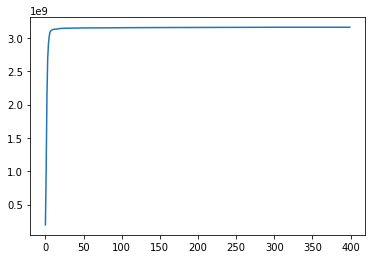

In [161]:
# plot losses
plt.plot(np.arange(num_steps), losses)

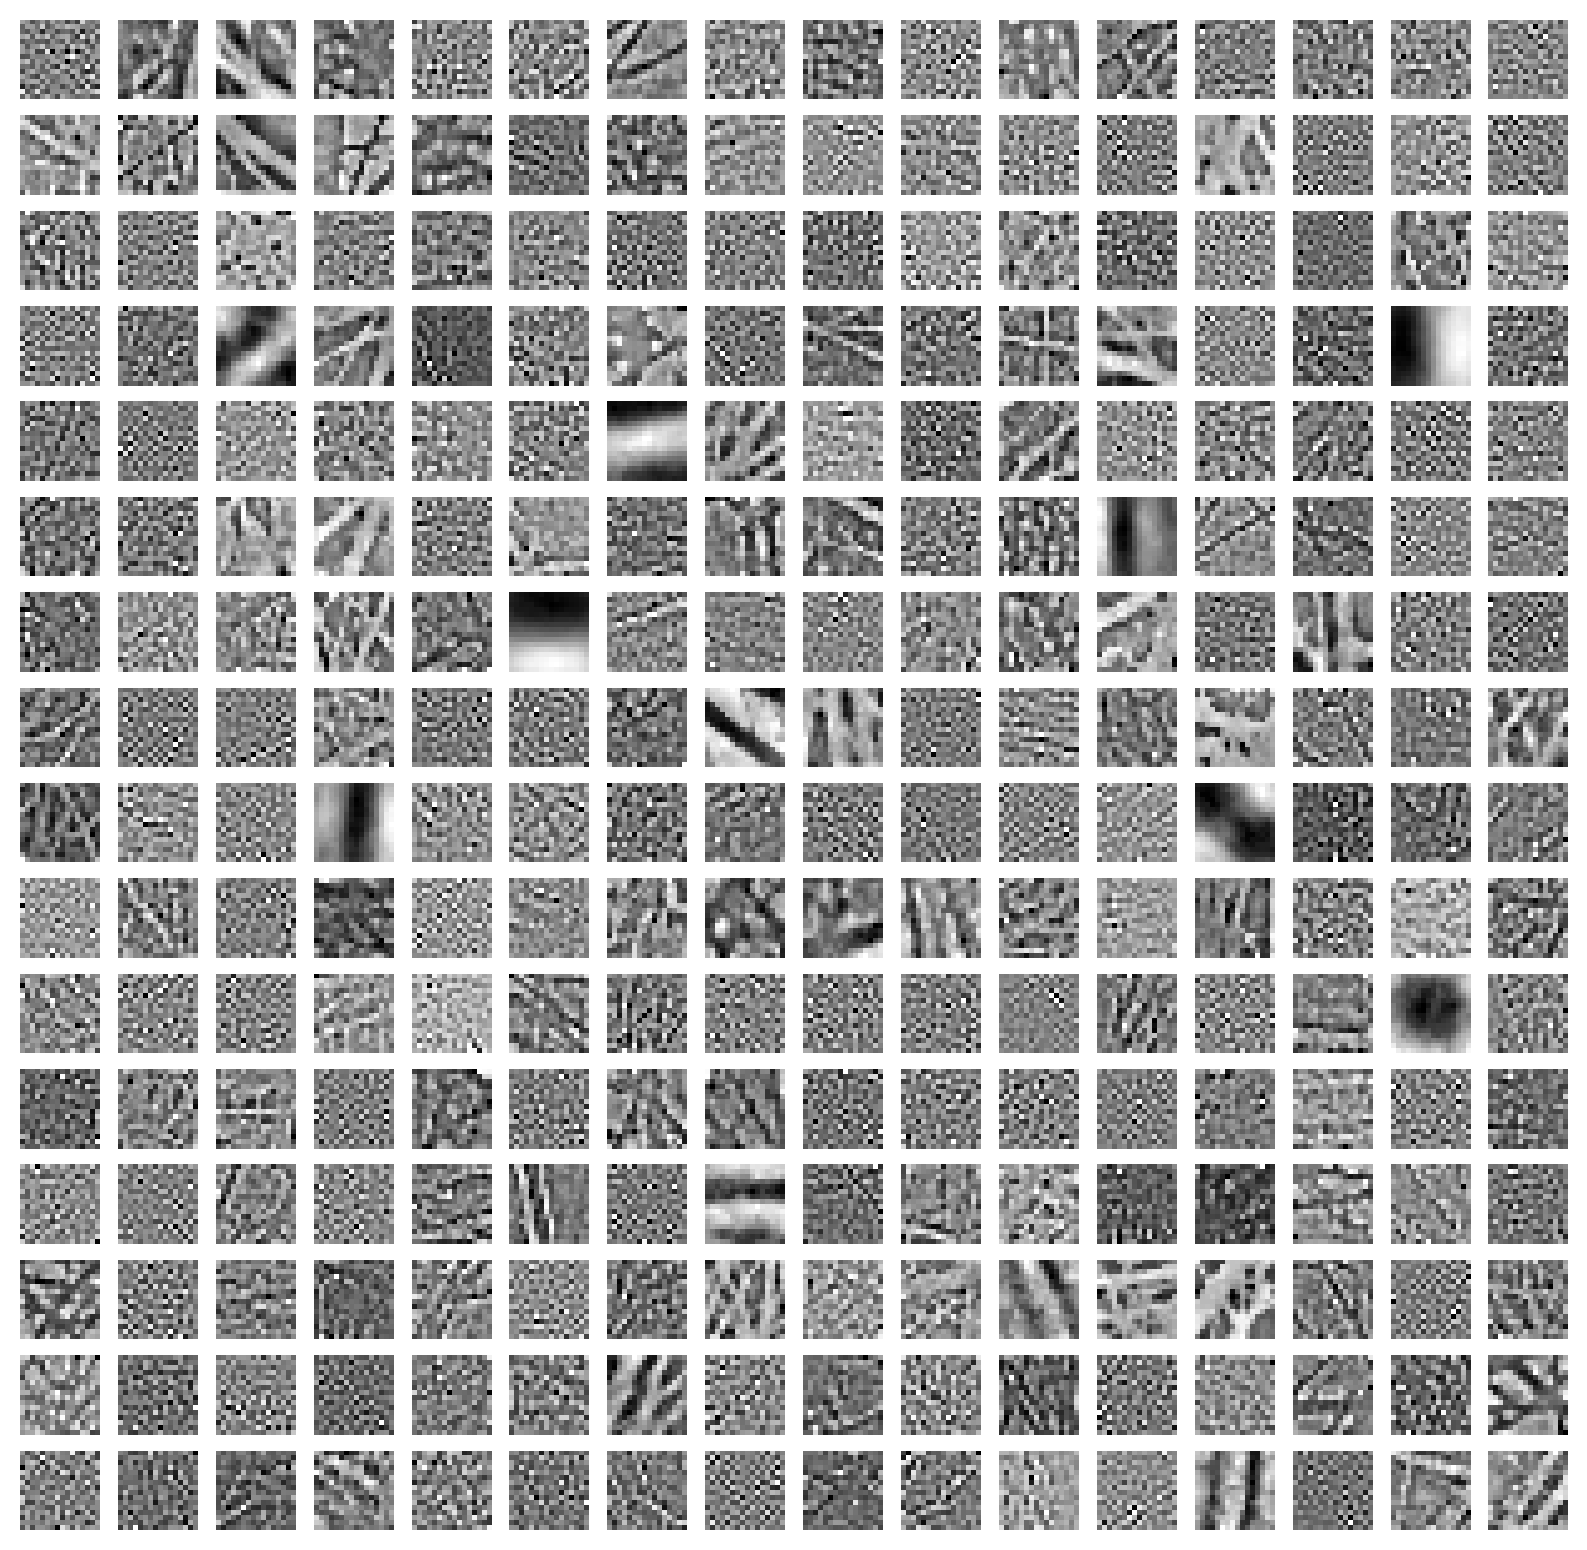

In [167]:
utils.plot_neurons(A.T)

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()['data']

In [ ]:
digits

In [ ]:
plt.imshow(A.T.reshape(16, 16), cmap="gray")

In [ ]:
transformer = FastICA(n_components=n, whiten=False, w_init=A)#, max_iter=num_steps)
X_transformed = transformer.fit(Y.T)

In [ ]:
utils.plot_neurons(transformer.components_.T)

In [ ]:
plt.imshow(transformer.components_.T[:, 200].reshape(16 ,16), cmap='gray')

In [ ]:
def read_4B(bytestream):
    dt = np.dtype(np.uint32).newbyteorder("B") #big-endian byte order-MSB first
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]
def read_img_header(bytestream):
    _ = read_4B(bytestream)
    num_img = read_4B(bytestream)
    img_rows = read_4B(bytestream)
    img_cols = read_4B(bytestream)
    return (num_img, img_rows, img_cols)
filename = 'train-images-idx3-ubyte.gz'
with open(filename, "rb") as f:
    with gzip.GzipFile(fileobj=f) as bytestream:
        num_img, img_rows, img_cols = read_img_header(bytestream)
        buf = bytestream.read(num_img*img_rows*img_cols)
        images = np.frombuffer(buf, dtype=np.uint8)
        images = images.reshape(num_img, img_rows, img_cols, 1).astype(np.float32) / 255.0

In [ ]:
# initialize model
num_imgs, im_h, im_w, _ = images.shape
n = 784
p = 500

Y = images[:p].reshape(p, im_h*im_w).T
X = np.random.rand(n, p) # shape: (n, p)
A = np.linalg.qr(np.random.rand(n, n))[0] # shape: (n, n)

losses = []
for t in range(num_steps):
    dA = np.power(A @ Y, 3) @ Y.T
    U, S, V = np.linalg.svd(dA, full_matrices=False, compute_uv=True)
    indices = np.argsort(S)[::-1]
    U = U[:, indices]
    V = V[indices, :]
    A = U @ V
    loss = np.sum(np.power(A @ Y, 4))
    losses.append(loss)
    print(f'step: {t}\tloss: {loss}')

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
path = './cifar-10-batches-py/'
files = os.listdir(path)

In [ ]:
img_arr = []
for file in files:
    if file[:4] != 'data':
        continue
    img_arr.append(unpickle(path+file)[b'data'])
img_arr = np.vstack(img_arr).reshape(-1, 32, 32, 3)
img_arr = utils.normalize_imgs(img_arr)
img_arr = utils.extract_patches(img_arr, p)

In [ ]:
# initialize model
num_imgs, im_h, im_w, _ = img_arr.shape
n = 16*16*3
p = 1000

Y = [:p].reshape(p, im_h*im_w).T
X = np.random.rand(n, p) # shape: (n, p)
A = np.linalg.qr(np.random.rand(n, n))[0] # shape: (n, n)

losses = []
for t in range(num_steps):
    dA = np.power(A @ Y, 3) @ Y.T
    U, S, V = np.linalg.svd(dA, full_matrices=False, compute_uv=True)
    indices = np.argsort(S)[::-1]
    U = U[:, indices]
    V = V[indices, :]
    A = U @ V
    loss = np.sum(np.power(A @ Y, 4))
    losses.append(loss)
    print(f'step: {t}\tloss: {loss}')

In [150]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [151]:
img_arr = x_train / 255.
# img_arr = utils.extract_patches(img_arr, p, patch_size=(16, 16))
# img_arr, wtn_mat = utils.whiten_imgs(img_arr)

In [152]:
Y = img_arr.reshape(-1, 784).T # shape: (n, p)

# # orthogonalize data
# Y_hat = (Y @ Y.T) / 256
# U, S, V = np.linalg.svd(Y_hat, full_matrices=False)
# S = np.power(S, -0.5)
# Y_hat = U @ np.diag(S) @ V
# Y_hat = Y_hat @ Y

In [111]:
# orthogonalize data
# Y_hat = (Y @ Y.T) 
# U, S, V = np.linalg.svd(Y_hat)
# S = np.power(S, -0.5)
# Y_hat = U @ np.diag(S) @ V
# Y_hat = Y_hat @ Y

In [153]:
n = 784
num_steps = 100
A = np.linalg.qr(np.random.rand(n, n))[0] # shape: (n, n)
# Y = Y_hat
losses = []
for t in range(num_steps):
    dA = np.power(A @ Y, 3) @ Y.T
    U, S, V = np.linalg.svd(dA, full_matrices=False, compute_uv=True)
    indices = np.argsort(S)[::-1]
    U = U[:, indices]
    V = V[indices, :]
    A = U @ V
    loss = np.sum(np.power(A @ Y, 4))
    losses.append(loss)
    print(f'step: {t}\tloss: {loss}')

step: 0	loss: 13785737.689583516
step: 1	loss: 92630341.79654808
step: 2	loss: 123101167.42989866
step: 3	loss: 132359427.42548348
step: 4	loss: 135739326.7035846
step: 5	loss: 137076029.66500646
step: 6	loss: 137818994.6389232
step: 7	loss: 138368844.21911138
step: 8	loss: 138803819.8878283
step: 9	loss: 139141430.24653715
step: 10	loss: 139393765.2120086
step: 11	loss: 139580990.170752
step: 12	loss: 139728543.46430272
step: 13	loss: 139854381.23187682
step: 14	loss: 139964373.18509537
step: 15	loss: 140057816.3901163
step: 16	loss: 140134090.37828758
step: 17	loss: 140194963.16482896
step: 18	loss: 140243615.0474673
step: 19	loss: 140283209.5599912
step: 20	loss: 140316214.19767037
step: 21	loss: 140344352.2112315
step: 22	loss: 140368812.95562506
step: 23	loss: 140390442.20841175
step: 24	loss: 140409853.0708164
step: 25	loss: 140427498.6841114
step: 26	loss: 140443723.85852283
step: 27	loss: 140458802.09452823
step: 28	loss: 140472959.5278732
step: 29	loss: 140486383.55748013
step

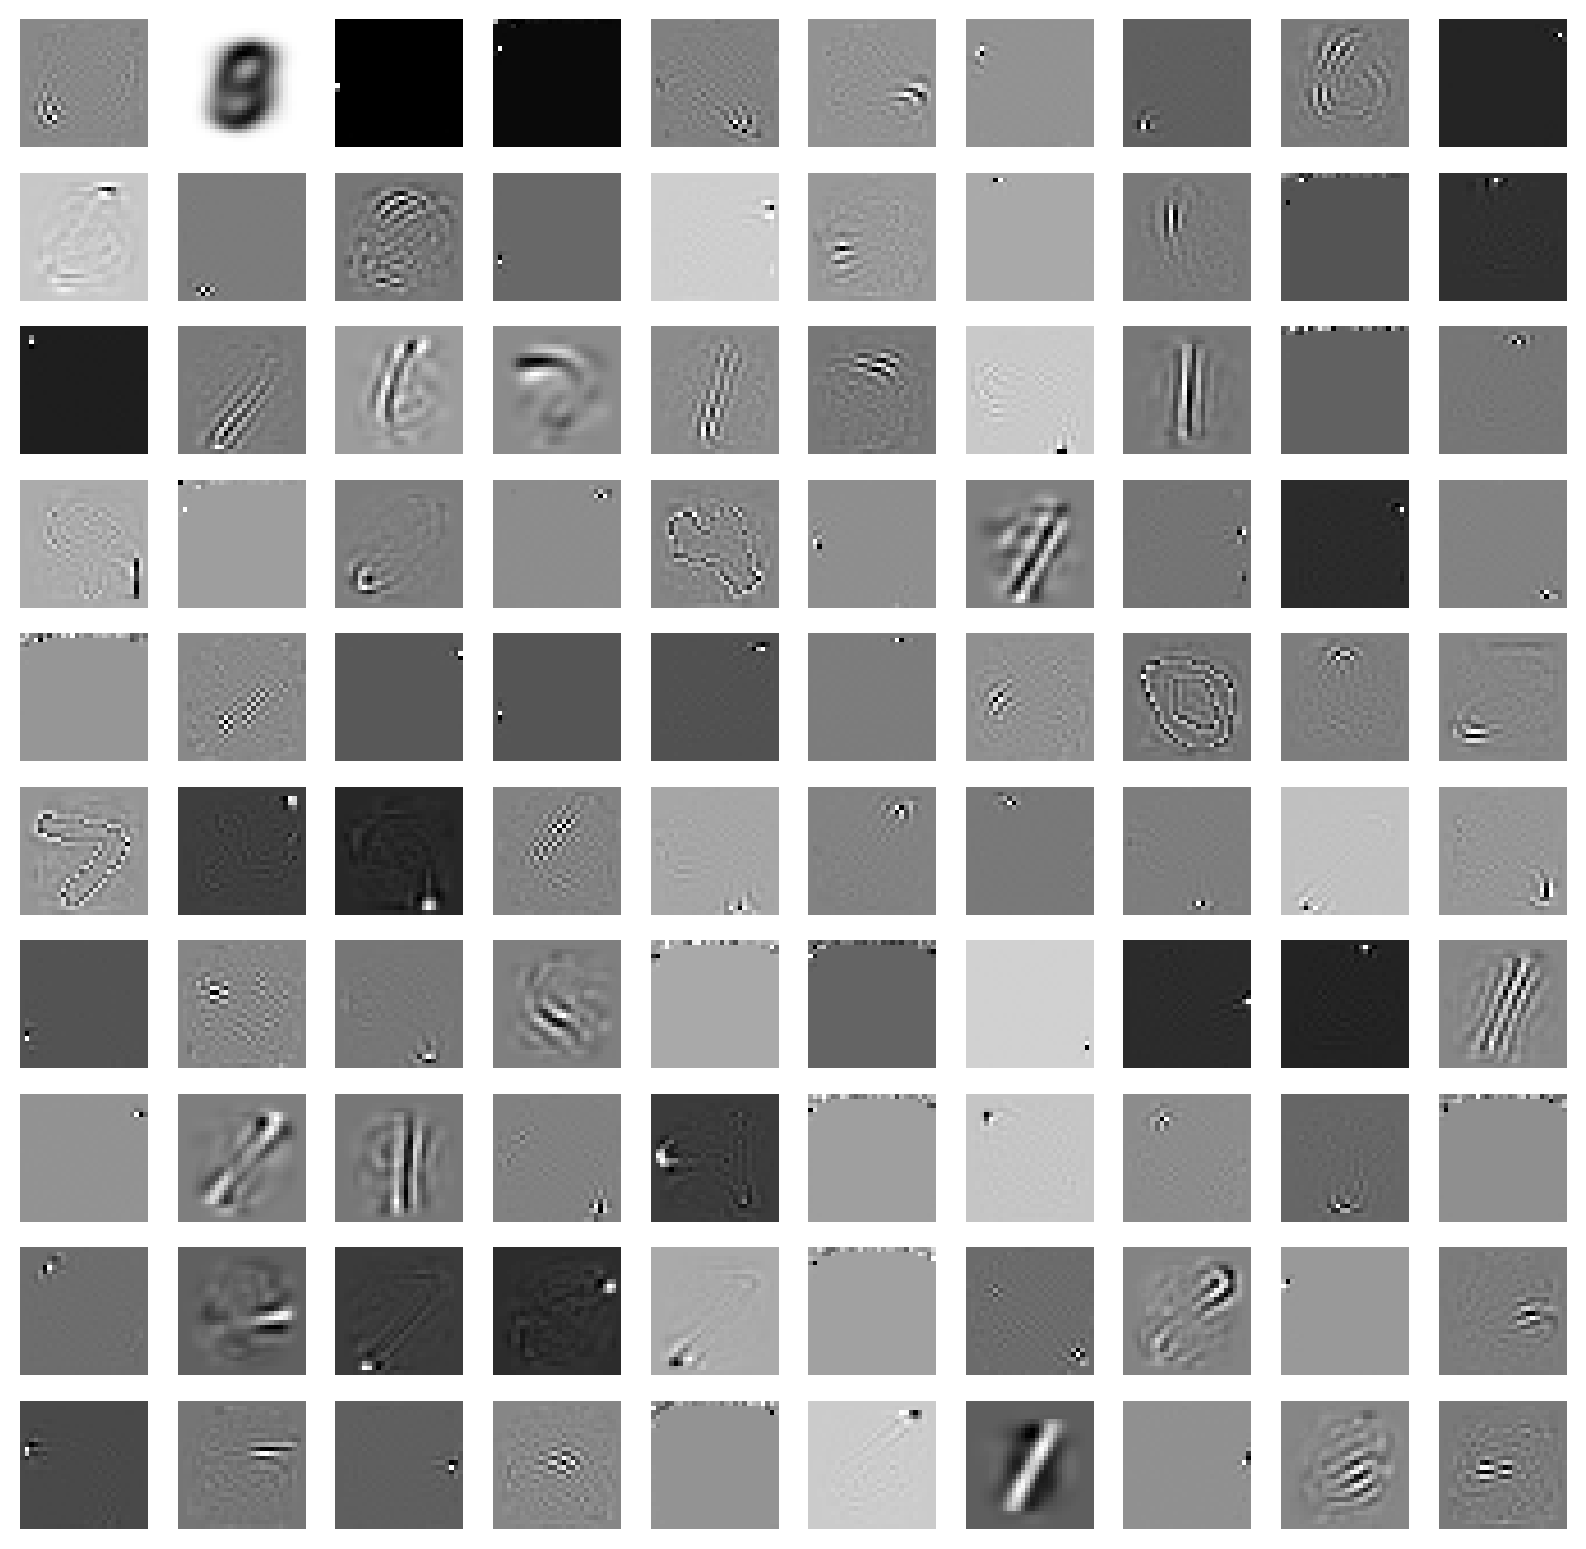

In [154]:
k = 0
col = 10
row = 10
fig, ax = plt.subplots(ncols=col, nrows=row, figsize=(10, 10), dpi=200)
for i in range(row):
    for j in range(col):
        ax[i, j].imshow(A[k].reshape(28, 28), cmap='gray')
        ax[i, j].set_axis_off()
        k += 1
plt.show()

In [117]:
np.linalg.norm(A.T @ Y)

(784,)

In [124]:
x = np.arange(15).reshape(3, 5)
np.linalg.norm(x, ord=1, axis=1)
np.sum(np.abs(x), axis=1)

array([10, 35, 60])

In [148]:
def normalize(A):
    A_ = []
    for i in range(784):
        X = A[i] - np.min(A[i])
        A_.append(X / np.max(X)) 
    return np.stack(A_)

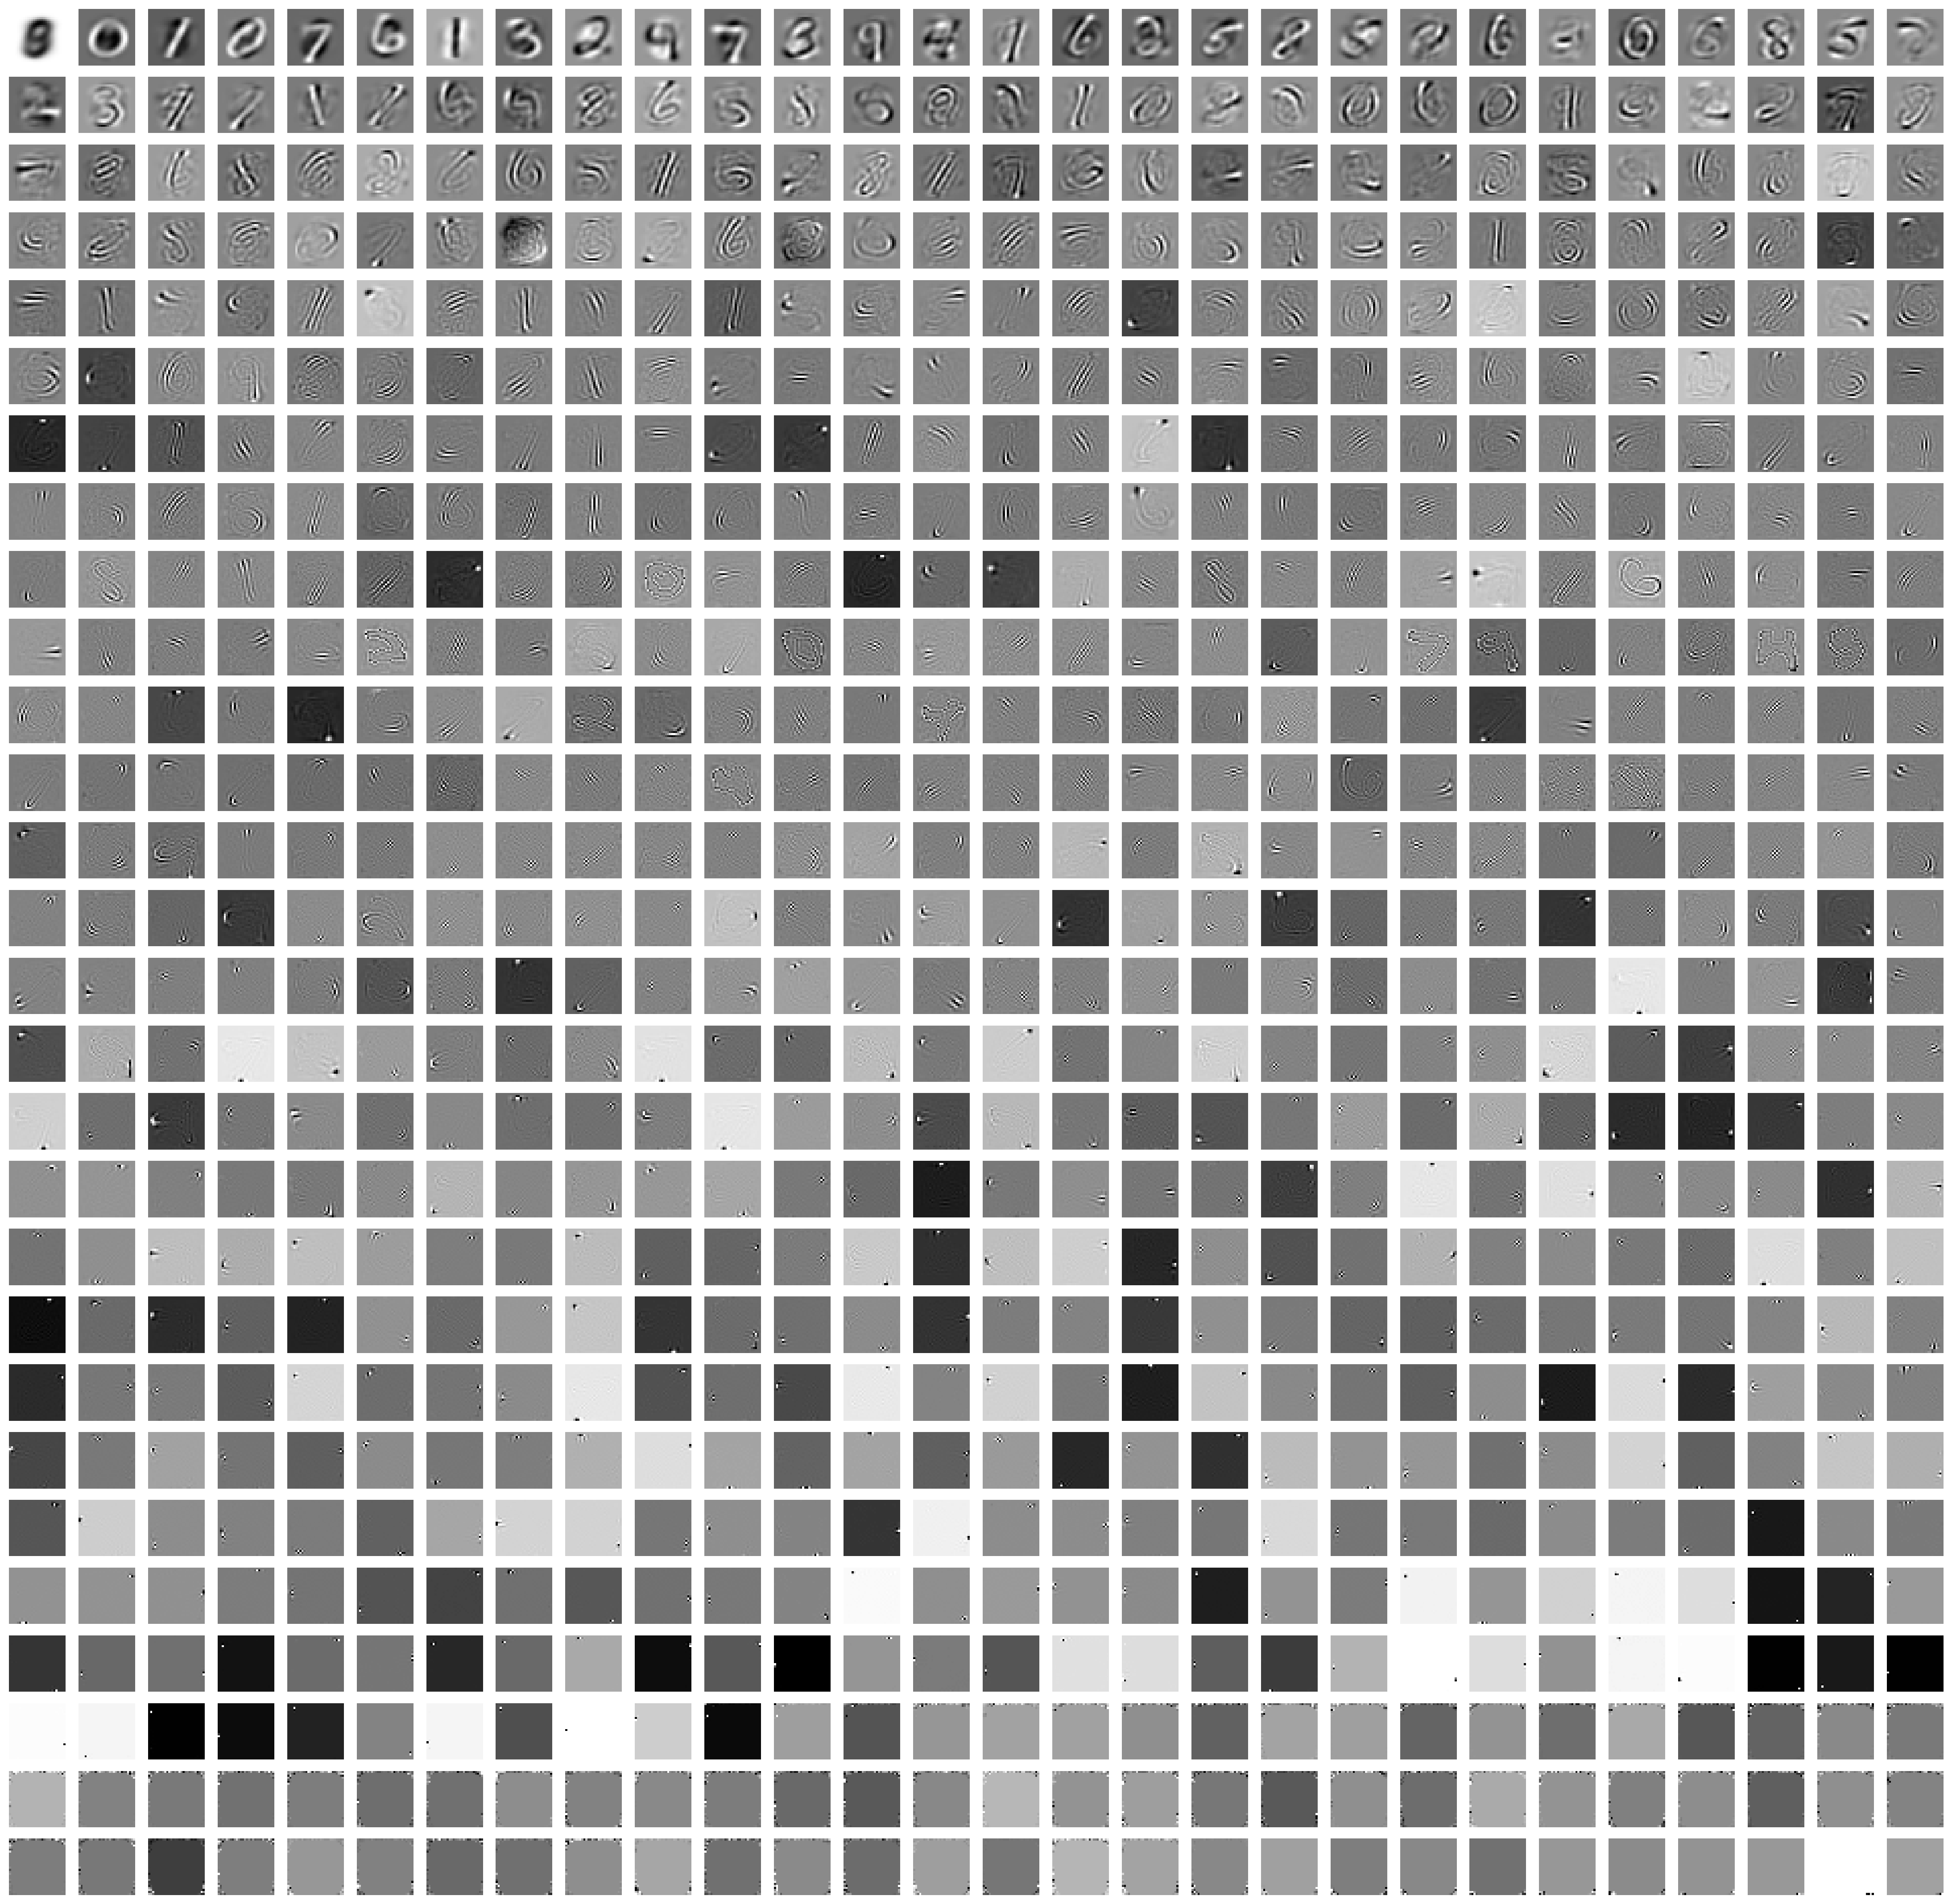

In [155]:
X = A @ Y
indices = np.argsort(np.linalg.norm(X, ord=1, axis=1))[::-1]
k = 0  
col = 28
row = 28
A_sort = A[indices]
A_sort = normalize(A_sort)
fig, ax = plt.subplots(ncols=col, nrows=row, figsize=(28, 28), dpi=200)
for i in range(row):
    for j in range(col):
        ax[i, j].imshow(A_sort[k].reshape(28, 28), cmap='gray')
        ax[i, j].set_axis_off()
        k += 1
plt.show()